## Importing the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # for converting to one-hot encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


## Data Preparation Phase

## Load dataset

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train.shape

(42000, 785)

In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.shape

(28000, 784)

## Extract X_train and y_train

In [7]:
X_train = train.drop('label', axis=1)

In [8]:
y_train = train.label

## free up space by deleting the train data

In [9]:
del train

## Inspect the target label

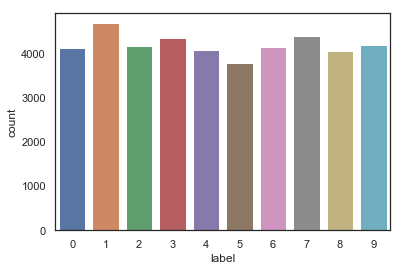

In [10]:
g = sns.countplot(y_train)

In [11]:
y_train.value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

## We can observe from above that the count for each digits is similar

## Check for missing and null values

In [12]:
X_train.isnull().sum().sum()

0

In [13]:
y_train.isnull().sum().sum()

0

In [14]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## From above, no missing values in the train and test set

## Grayscale Normalization to reduce the effect of illumination differences
### CNN converge faster on [0..1] data than on [0..255]

In [15]:
X_train = X_train / 255.0

In [16]:
test = test / 255.0

## Reshape image in 3 dimensions (height = 28px, width = 28px, canal = 1)

In [17]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## Label Encoding

In [18]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes=10)

## Spliting training and validation set

In [19]:
random_seed = 2

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_seed)

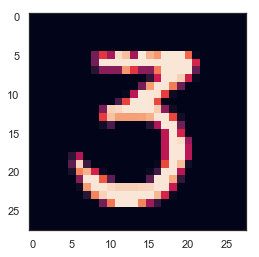

In [21]:
g = plt.imshow(X_train[3][:,:,0])

## Defining the convolutional neural network 

In [22]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Setting the optimizer and annealer

In [23]:
# define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [24]:
# compile the model
model.compile(optimizer = optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
# set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience=3,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

In [26]:
X_train.shape[0]

37800

In [30]:
epochs = 30
batch_size = 86

## Data Augmentation

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

## Fit the model

In [32]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                             epochs=epochs, validation_data=(X_val, y_val),
                             verbose=2, steps_per_epoch=X_train.shape[0] // batch_size,
                             callbacks=[learning_rate_reduction])

Epoch 1/30
 - 113s - loss: 0.1322 - acc: 0.9599 - val_loss: 0.0556 - val_acc: 0.9833
Epoch 2/30
 - 590s - loss: 0.0967 - acc: 0.9711 - val_loss: 0.0407 - val_acc: 0.9871
Epoch 3/30
 - 105s - loss: 0.0825 - acc: 0.9760 - val_loss: 0.0431 - val_acc: 0.9855
Epoch 4/30
 - 110s - loss: 0.0760 - acc: 0.9781 - val_loss: 0.0304 - val_acc: 0.9905
Epoch 5/30
 - 107s - loss: 0.0687 - acc: 0.9803 - val_loss: 0.0335 - val_acc: 0.9912
Epoch 6/30
 - 104s - loss: 0.0656 - acc: 0.9810 - val_loss: 0.0254 - val_acc: 0.9924
Epoch 7/30
 - 104s - loss: 0.0622 - acc: 0.9823 - val_loss: 0.0225 - val_acc: 0.9948
Epoch 8/30
 - 104s - loss: 0.0619 - acc: 0.9822 - val_loss: 0.0303 - val_acc: 0.9929
Epoch 9/30
 - 193s - loss: 0.0597 - acc: 0.9831 - val_loss: 0.0402 - val_acc: 0.9912
Epoch 10/30
 - 111s - loss: 0.0607 - acc: 0.9831 - val_loss: 0.0242 - val_acc: 0.9933

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 11/30
 - 115s - loss: 0.0476 - acc: 0.9867 - val_loss: 0.0193 

## Model Evaluation

## Training and validation 

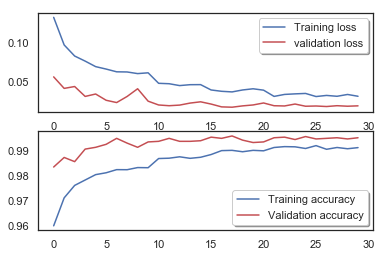

In [33]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### We can observe that the validation accuracy is always greater than the training accuracy, this shows that the model is well trained and does not overfit

## Calculating the confusion matrix

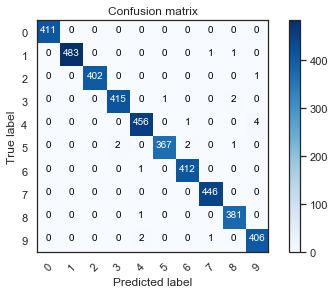

In [34]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

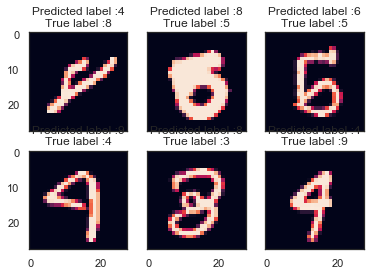

In [35]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_delta_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

## Result Prediction

In [36]:
# predict results
results = model.predict(test)

# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

## Generate a submission file

In [37]:
submission_cnn = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission_cnn.to_csv("cnn_digit_recognizer_mnist.csv",index=False)